[ENGLISH TRANSLATION REQUIRED] 
# 🧪 Lab: K-Fold, Stratified K-Fold, และ Group K-Fold (scikit-learn)

**วัตถุประสงค์ของแลบนี้**  
- เข้าใจแนวคิดและความแตกต่างของตัวแบ่งพับสำหรับ Cross-Validation
- ทดลองใช้ `KFold`, `StratifiedKFold`, `GroupKFold`
- ตรวจสอบสัดส่วนคลาสและการรั่วของกลุ่มในแต่ละพับ
- โค้ดสั้น อ่านง่าย เหมาะกับผู้เริ่มต้น


In [13]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold

np.random.seed(42)
print("Libraries ready.")


Libraries ready.


[ENGLISH TRANSLATION REQUIRED] 
## 2) สร้างชุดข้อมูลตัวอย่างอย่างง่าย
เราจะสร้างข้อมูลจำลองสำหรับ **classification** ที่มีคลาสไม่สมดุล และมี **กลุ่ม (groups)** เพื่อใช้กับตัวอย่าง Group K-Fold

- ฟีเจอร์ `X` จะเป็นตัวเลขง่ายๆ เพื่อเน้นที่การแบ่งพับ ไม่ใช่ประสิทธิภาพโมเดล
- เลเบล `y` จะมีสัดส่วน 0:1 = 3:1 (ไม่สมดุลเล็กน้อย)
- กลุ่ม `groups` จะเป็นหมายเลขกลุ่ม เช่น ผู้ใช้ 1..10


In [14]:

# ขนาดข้อมูล
n_groups = 10
items_per_group = 12  # รวมทั้งชุด = 120 แถว

# สร้างกลุ่ม
groups = np.repeat(np.arange(1, n_groups + 1), items_per_group)

# ฟีเจอร์อย่างง่าย: สุ่มตัวเลขปกติ
X = np.random.normal(loc=0.0, scale=1.0, size=(n_groups * items_per_group, 2))

# สร้างเลเบลไม่สมดุล: 0 มากกว่า 1
# ทำให้กลุ่มต้นๆ มีแนวโน้มเป็นคลาส 0 มากกว่าเล็กน้อย
y = np.zeros(n_groups * items_per_group, dtype=int)
mask_minority = np.random.rand(n_groups * items_per_group) < 0.25  # ประมาณ 25% เป็นคลาส 1
y[mask_minority] = 1

# แปลงเป็น DataFrame เพื่อดูภาพรวมง่ายๆ
df = pd.DataFrame(X, columns=["x1", "x2"])
df["y"] = y
df["group"] = groups

df


,x1,x2,y,group
0,0.496714,-0.138264,0,1
1,0.647689,1.523030,1,1
2,-0.234153,-0.234137,1,1
3,1.579213,0.767435,0,1
4,-0.469474,0.542560,0,1
...,...,...,...,...
115,-0.730367,0.216459,0,10
116,0.045572,-0.651600,0,10
117,2.143944,0.633919,0,10
118,-2.025143,0.186454,0,10


<Axes: title={'center': 'Group Distribution'}, xlabel='group'>

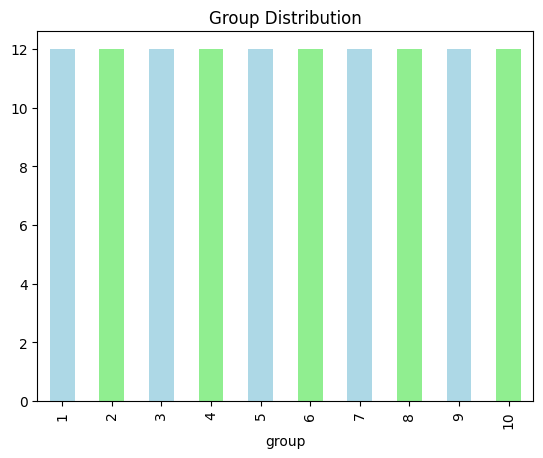

In [15]:
df['group'].value_counts().plot(kind='bar', title='Group Distribution', color=['lightblue', 'lightgreen'])

<Axes: title={'center': 'Class Distribution'}, xlabel='y'>

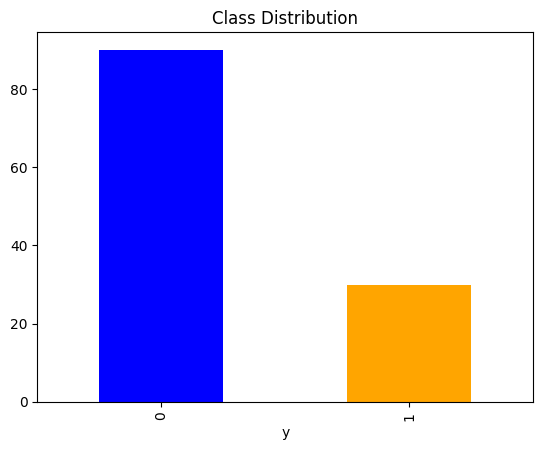

In [16]:
df['y'].value_counts().plot(kind='bar', title='Class Distribution', color=['blue', 'orange'])

In [17]:
groups

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10])

[ENGLISH TRANSLATION REQUIRED] 
## 3) ดูสัดส่วนคลาสรวม และจำนวนแถวต่อกลุ่ม
เพื่อให้แน่ใจว่าเข้าใจข้อมูลก่อนเริ่มแบ่งพับ

### ตัวอย่างเชิงรูปธรรม
- พิมพ์ `y.value_counts(normalize=True)` เพื่อดูสัดส่วนรวม
- พล็อตฮิสโตแกรมของ `x1`, `x2` อย่างง่าย เพื่อเห็นการกระจายเบื้องต้น
- แสดงจำนวนแถวต่อกลุ่มด้วย `df.groupby('group').size()`

**ข้อควรจำ**
- ดูข้อมูลคร่าวๆ ก่อนเสมอ จะได้เลือกตัวแบ่งพับที่เหมาะ


รวมทั้งชุด: สัดส่วนคลาส = {0: 90, 1: 30}


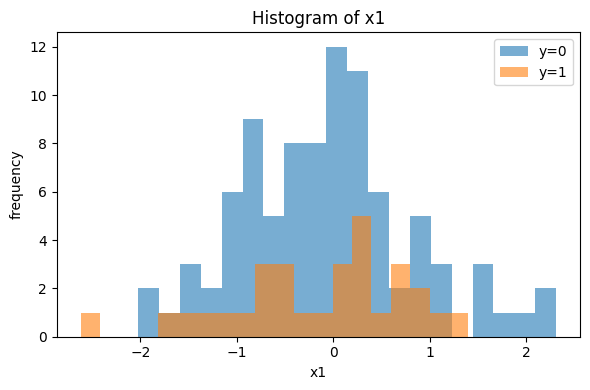

In [18]:

# สัดส่วนคลาสรวม
total_dist = dict(Counter(df["y"]))
print("รวมทั้งชุด: สัดส่วนคลาส =", total_dist)

# ตัวอย่างสรุปกลุ่ม
group_sizes = df.groupby("group").size()

# วาดฮิสโตแกรมเล็กๆ ของฟีเจอร์ x1 แยกตามคลาส (รวมเป็นกราฟเดียว)
plt.figure(figsize=(6,4))
plt.hist(df.loc[df.y==0, "x1"], bins=20, alpha=0.6, label="y=0")
plt.hist(df.loc[df.y==1, "x1"], bins=20, alpha=0.6, label="y=1")
plt.title("Histogram of x1")
plt.xlabel("x1")
plt.ylabel("frequency")
plt.legend()
plt.tight_layout()
plt.show()



## 4.5) Train-Test Split
Before diving into cross-validation methods, let's quickly perform a **train-test split** to see the basic way of splitting data into training and testing sets.

We will use `train_test_split` from `sklearn.model_selection`.

### ตัวอย่างเชิงรูปธรรม
- แบ่ง 80/20 ด้วย `train_test_split`
- ทดลอง `shuffle=False` เทียบกับ `shuffle=True` แล้วสังเกตการกระจายของ `y`
- เมื่อ `y` ไม่สมดุล ให้ลอง `stratify=y` เพื่อรักษาสัดส่วนคลาส

**ข้อผิดพลาดที่พบบ่อย**
- ใส่ `stratify=y` ทั้งที่ `y` เป็นการถดถอยหรือมีค่าไม่ซ้ำเยอะ ทำให้ error ได้


In [19]:
from sklearn.model_selection import train_test_split

# Separate features and target
X = df[['x1', 'x2']]
y = df['y']

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Prepare counts and proportions
train_counts = y_train.value_counts().to_dict()
test_counts  = y_test.value_counts().to_dict()
train_props  = y_train.value_counts(normalize=True).to_dict()
test_props   = y_test.value_counts(normalize=True).to_dict()

print("Train size:", len(y_train), "rows")
print("Test size :", len(y_test), "rows")
print(f"Train class counts     : {train_counts}")
print(f"Test  class counts     : {test_counts}")
print(f"Train class proportions: {train_props}")
print(f"Test  class proportions: {test_props}")


Train size: 96 rows
Test size : 24 rows
Train class counts     : {0: 70, 1: 26}
Test  class counts     : {0: 20, 1: 4}
Train class proportions: {0: 0.7291666666666666, 1: 0.2708333333333333}
Test  class proportions: {0: 0.8333333333333334, 1: 0.16666666666666666}


[ENGLISH TRANSLATION REQUIRED] 
## 5) K-Fold
**แนวคิด:** แบ่งข้อมูลเป็น K ส่วนเท่าๆ กัน สลับกันเอา 1 ส่วนเป็น validation และที่เหลือเป็น train โดย **ไม่บังคับสัดส่วนคลาส** และ **ไม่คำนึงถึงกลุ่ม**

**ใช้เมื่อ:**  
- ไม่มีคลาสไม่สมดุลรุนแรง
- ไม่มีความสัมพันธ์ซ้ำๆ ที่ต้องกันการรั่วระหว่าง train กับ val

### ตัวอย่างเชิงรูปธรรม
- ใช้ `KFold(n_splits=5, shuffle=True, random_state=42)`
- โฟกัสดูสัดส่วนคลาสของแต่ละพับ จะเห็นว่าอาจเบี้ยวได้ เพราะ K-Fold ไม่รู้เรื่องคลาส

**เหมาะกับ**
- รีเกรสชัน หรือคลาสที่ค่อนข้างสมดุล และไม่มีความสัมพันธ์เป็นกลุ่ม


In [20]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)

fold = 0
for train_index, test_index in kf.split(X):
    fold += 1
    y_train = y.iloc[train_index]
    y_test  = y.iloc[test_index]

    train_counts = y_train.value_counts().sort_index().to_dict()
    test_counts  = y_test.value_counts().sort_index().to_dict()
    train_props  = y_train.value_counts(normalize=True).sort_index().to_dict()
    test_props   = y_test.value_counts(normalize=True).sort_index().to_dict()

    print(f"Fold {fold}")
    print(f"Train size: {len(y_train)}, Test size: {len(y_test)}")
    print(f"Train class counts     : {train_counts}")
    print(f"Test  class counts     : {test_counts}")
    print(f"Train class proportions : {train_props}")
    print(f"Test  class proportions : {test_props}")
    print("-" * 50)


Fold 1
Train size: 96, Test size: 24
Train class counts     : {0: 70, 1: 26}
Test  class counts     : {0: 20, 1: 4}
Train class proportions : {0: 0.7291666666666666, 1: 0.2708333333333333}
Test  class proportions : {0: 0.8333333333333334, 1: 0.16666666666666666}
--------------------------------------------------
Fold 2
Train size: 96, Test size: 24
Train class counts     : {0: 72, 1: 24}
Test  class counts     : {0: 18, 1: 6}
Train class proportions : {0: 0.75, 1: 0.25}
Test  class proportions : {0: 0.75, 1: 0.25}
--------------------------------------------------
Fold 3
Train size: 96, Test size: 24
Train class counts     : {0: 71, 1: 25}
Test  class counts     : {0: 19, 1: 5}
Train class proportions : {0: 0.7395833333333334, 1: 0.2604166666666667}
Test  class proportions : {0: 0.7916666666666666, 1: 0.20833333333333334}
--------------------------------------------------
Fold 4
Train size: 96, Test size: 24
Train class counts     : {0: 73, 1: 23}
Test  class counts     : {0: 17, 1: 7}

[ENGLISH TRANSLATION REQUIRED] 
## 6) Stratified K-Fold
**แนวคิด:** เหมือน K-Fold แต่ **รักษาสัดส่วนคลาส** ในแต่ละพับให้ใกล้เคียงทั้งชุด

**ใช้เมื่อ:**  
- ปัญหาเป็น **classification**
- คลาส **ไม่สมดุล** และต้องการประเมินอย่างยุติธรรม

### ตัวอย่างเชิงรูปธรรม
- ใช้ `StratifiedKFold(n_splits=5, shuffle=True, random_state=42)`
- ดูสัดส่วนคลาสของ train/test ในแต่ละพับ จะใกล้เคียงกันกว่ามาก

**เหมาะกับ**
- งานจัดหมวดหมู่ที่คลาสไม่สมดุล ต้องการรักษาสัดส่วนคลาสทุกพับ


In [21]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), start=1):
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    train_counts = y_train.value_counts().to_dict()
    test_counts  = y_test.value_counts().to_dict()
    train_props  = y_train.value_counts(normalize=True).to_dict()
    test_props   = y_test.value_counts(normalize=True).to_dict()

    print(f"Fold {fold}")
    print(f"Train size: {len(train_idx)}, Test size: {len(test_idx)}")
    print(f"Train class counts     : {train_counts}")
    print(f"Test  class counts     : {test_counts}")
    print(f"Train class proportions: {train_props}")
    print(f"Test  class proportions: {test_props}")
    print("-" * 50)


Fold 1
Train size: 96, Test size: 24
Train class counts     : {0: 72, 1: 24}
Test  class counts     : {0: 18, 1: 6}
Train class proportions: {0: 0.75, 1: 0.25}
Test  class proportions: {0: 0.75, 1: 0.25}
--------------------------------------------------
Fold 2
Train size: 96, Test size: 24
Train class counts     : {0: 72, 1: 24}
Test  class counts     : {0: 18, 1: 6}
Train class proportions: {0: 0.75, 1: 0.25}
Test  class proportions: {0: 0.75, 1: 0.25}
--------------------------------------------------
Fold 3
Train size: 96, Test size: 24
Train class counts     : {0: 72, 1: 24}
Test  class counts     : {0: 18, 1: 6}
Train class proportions: {0: 0.75, 1: 0.25}
Test  class proportions: {0: 0.75, 1: 0.25}
--------------------------------------------------
Fold 4
Train size: 96, Test size: 24
Train class counts     : {0: 72, 1: 24}
Test  class counts     : {0: 18, 1: 6}
Train class proportions: {0: 0.75, 1: 0.25}
Test  class proportions: {0: 0.75, 1: 0.25}
-------------------------------

[ENGLISH TRANSLATION REQUIRED] 
## 7) Group K-Fold
**แนวคิด:** แบ่งด้วย **กลุ่ม** โดย **กลุ่มเดียวกันจะอยู่ได้แค่พับเดียว** จึงช่วยกันข้อมูลรั่วระหว่าง train กับ val ได้ดีเมื่อข้อมูลในกลุ่มมีลักษณะคล้ายกันมาก

**ใช้เมื่อ:**  
- มีตัวตนซ้ำๆ เช่น `user_id`, `session_id`, `product_id`
- ต้องการให้ข้อมูลของกลุ่มเดียวกันไม่โผล่ทั้งใน train และ val พร้อมกัน

### ตัวอย่างเชิงรูปธรรม
- ใช้ `GroupKFold(n_splits=5)` โดยส่ง `groups` เข้าไปใน `split(X, y, groups)`
- ตรวจสอบว่ากลุ่มใน train กับ test ไม่ซ้ำกันเลยในแต่ละพับ

**เหมาะกับ**
- ข้อมูลที่มีหลายแถวต่อผู้ใช้/สินค้า/เซสชันเดียวกัน ต้องหลีกเลี่ยงการรั่วไหลระหว่าง train กับ test


In [22]:
from sklearn.model_selection import GroupKFold

gkf = GroupKFold(n_splits=5)

for fold, (train_idx, test_idx) in enumerate(gkf.split(X, y, groups=groups), start=1):
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    train_counts = y_train.value_counts().to_dict()
    test_counts  = y_test.value_counts().to_dict()
    train_props  = y_train.value_counts(normalize=True).to_dict()
    test_props   = y_test.value_counts(normalize=True).to_dict()

    print(f"Fold {fold}")
    print(f"Train size: {len(train_idx)}, Test size: {len(test_idx)}")
    print(f"Train groups: {set(groups[train_idx])}")
    print(f"Test  groups: {set(groups[test_idx])}")
    print(f"Train class counts     : {train_counts}")
    print(f"Test  class counts     : {test_counts}")
    print(f"Train class proportions: {train_props}")
    print(f"Test  class proportions: {test_props}")
    print("-" * 50)


Fold 1
Train size: 96, Test size: 24
Train groups: {1, 2, 3, 4, 6, 7, 8, 9}
Test  groups: {10, 5}
Train class counts     : {0: 71, 1: 25}
Test  class counts     : {0: 19, 1: 5}
Train class proportions: {0: 0.7395833333333334, 1: 0.2604166666666667}
Test  class proportions: {0: 0.7916666666666666, 1: 0.20833333333333334}
--------------------------------------------------
Fold 2
Train size: 96, Test size: 24
Train groups: {1, 2, 3, 5, 6, 7, 8, 10}
Test  groups: {9, 4}
Train class counts     : {0: 72, 1: 24}
Test  class counts     : {0: 18, 1: 6}
Train class proportions: {0: 0.75, 1: 0.25}
Test  class proportions: {0: 0.75, 1: 0.25}
--------------------------------------------------
Fold 3
Train size: 96, Test size: 24
Train groups: {1, 2, 4, 5, 6, 7, 9, 10}
Test  groups: {8, 3}
Train class counts     : {0: 71, 1: 25}
Test  class counts     : {0: 19, 1: 5}
Train class proportions: {0: 0.7395833333333334, 1: 0.2604166666666667}
Test  class proportions: {0: 0.7916666666666666, 1: 0.20833333

## ตารางสรุปการเลือกตัวแบ่งพับ

| Splitter | รักษาสัดส่วนคลาส? | กันกลุ่มรั่วไหล? | ใช้เมื่อไหร่ |
|---|---|---|---|
| K-Fold | ไม่ | ไม่ | งานทั่วไปที่ไม่มี imbalance และไม่มีโครงสร้างกลุ่ม |
| Stratified K-Fold | ใช่ | ไม่ | จัดหมวดหมู่ที่คลาสไม่สมดุล ต้องการสัดส่วนใกล้เคียงทุกพับ |
| Group K-Fold | ไม่ | ใช่ | มีหลายแถวต่อผู้ใช้/สินค้า/เซสชัน ต้องกันข้อมูลข้ามกัน |

> เคล็ดลัด: ถ้าคุณลังเลระหว่างสามตัวนี้ ให้ถามสองคำถาม:  
> 1) มีความสัมพันธ์เป็นกลุ่มหรือไม่? ถ้าใช่ ให้ใช้ Group K-Fold  
> 2) คลาสไม่สมดุลหรือไม่? ถ้าใช่ ให้ใช้ Stratified K-Fold  
> ถ้าไม่ใช่ทั้งคู่ ใช้ K-Fold ได้เลย